In [ ]:
# CV ImageSegmentation VGG16 Transfer Learning From Scratch

In [1]:

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications

In [2]:
# https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
ds_name = 'oxford_iiit_pet:3.*.*' # 'oxford_iiit_pet'
input_shape = (None, None, 3)

Metal device set to: Apple M1
FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
37
['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


2022-04-28 18:00:23.179444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 18:00:23.179596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-28 18:00:23.244562: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(TensorShape([500, 500, 3]), TensorShape([500, 500, 1]))

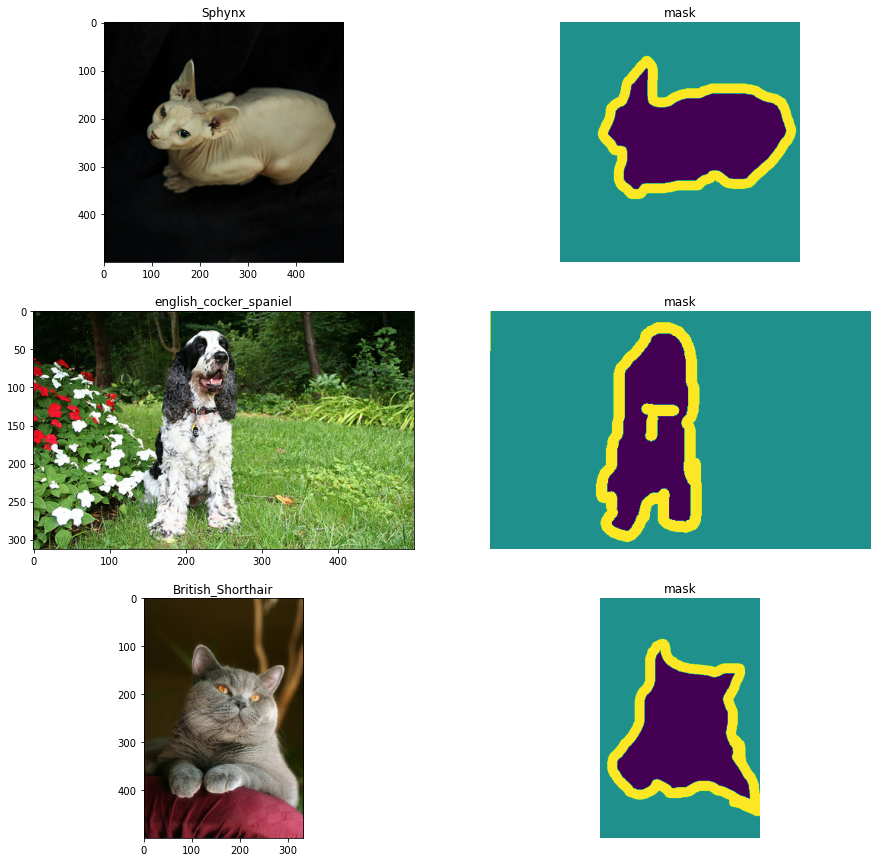

In [3]:

# load dataset
# code adapted from https://www.tensorflow.org/tutorials/images/segmentation

(train_ds, val_ds, test_ds), metadata = tfds.load(
    # more datasets: https://www.tensorflow.org/datasets/catalog/overview#all_datasets
    name=ds_name,
    # more info: https://www.tensorflow.org/datasets/splits
    split=['train', 'test[:75%]', 'test[75%:]'], 
    # return metadata
    with_info=True, 
    # download data
    download=True, 
    # whether to shuffle the files between each epoch
    shuffle_files=False, 
)

print (metadata.features)

# num classes
num_classes = metadata.features['label'].num_classes
print (num_classes)

# class labels
class_names = metadata.features['label'].names
print (class_names)

plt.figure(figsize=(15, 15))
i = 0
for datapoint in train_ds.take(3):
    label = datapoint['label']
    image = datapoint['image']
    mask = datapoint['segmentation_mask']
    ax = plt.subplot(3, 2, i + 1)
    plt.title(class_names[label])
    plt.imshow(image.numpy().astype("uint8"))
    ax = plt.subplot(3, 2, i + 2)
    plt.title('mask')
    plt.imshow(mask.numpy().astype("uint8"))
    plt.axis("off")
    i = i + 2
    
# get shape of images and masks 
iter(train_ds).get_next()['image'].shape, iter(train_ds).get_next()['segmentation_mask'].shape

In [4]:

# configure dataset for performance
# code adapted from https://www.tensorflow.org/guide/data_performance

IMG_SIZE = 128
batch_size = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, resize=False, normalize=False, augment=False):
    
    # Extract just image and segmentation_mask
    ds = ds.map(lambda x: (x['image'], x['segmentation_mask']))
    
    # Resize dataset 
    if resize:
        resizing = preprocessing.Resizing(IMG_SIZE,IMG_SIZE)
        ds = ds.map(lambda image, mask: (resizing(image), resizing(mask)))

    # Augment dataset (should only be applied to training data)
    if augment:
        ds = ds.map(lambda image, mask: (tf.image.flip_left_right(image), tf.image.flip_left_right(mask)) if tf.random.uniform(()) > 0.5 else (image, mask))
        
    # Normalize dataset 
    if normalize:
        # image will now have values 0-1 (instead of 0-255)
        # mask will now have values 0, 1, 2 (instead of 1, 2, 3)
        ds = ds.map(lambda image, mask: (image/255.0, mask-1)) 
    
    # Batch dataset
    # Note: To be batched, images need to share the same height and width.
    #          So if dataset has images of different sizes, resize them before batching
    ds = ds.batch(batch_size)
    
    # The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory;
    #   subsequent iterations will use the cached data.
    #   Note: cache will produce exactly the same elements during each iteration through the dataset;
    #     if you wish to randomize the iteration order, make sure to call shuffle after calling cache.
    ds = ds.cache()
    
    # Shuffle the data. 
    #   buffer_size: this dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, 
    #     replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to 
    #     the full size of the dataset is required.
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE, seed=None)

    # Prefetching overlaps the preprocessing and model execution of a training step. 
    #   While the model is executing training step s, the input pipeline is reading the data for step s+1
    ds = ds.prefetch(buffer_size=AUTOTUNE)
        
    return ds

train_ds = prepare(train_ds, shuffle=True, resize=True, normalize=True, augment=True)
val_ds = prepare(val_ds, resize=True, normalize=True)
test_ds = prepare(test_ds, resize=True, normalize=True)

# get shape of images and masks 
iter(train_ds).get_next()[0].shape, iter(train_ds).get_next()[1].shape

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(TensorShape([64, 128, 128, 3]), TensorShape([64, 128, 128, 1]))

In [5]:
### downsampling path - VGG16 
backbone = applications.VGG16(input_shape=(128, 128, 3), include_top=False)
backbone.trainable = False
down1 = backbone.get_layer('block1_pool').output
down2 = backbone.get_layer('block2_pool').output
down3 = backbone.get_layer('block3_pool').output
down4 = backbone.get_layer('block4_pool').output
down5 = backbone.get_layer('block5_pool').output

### use the functional API to create the upsampling path
### NOTE: you will need to pass the output of each step as input to the next step
#  upsampling block 1
#   - transpose convolution with 512 filters, 3x3 kernel, stride of 2, same padding, relu activation
#      (input to this ranspose convolution layer is down5)
#   - batch norm (with default parameters)
#   - concatenate with down4
block1 = layers.Conv2DTranspose(filters=512, kernel_size=(3,3), strides=(2,2), padding='same',activation='relu')(down5)
block1 = layers.BatchNormalization()(block1)
output1 = layers.concatenate([block1,down4])

#  upsampling block 2
#   - transpose convolution with 256 filters, 3x3 kernel, stride of 2, same padding, relu activation 
#   - batch norm (with default parameters)
#   - concatenate with down3
block2 = layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(2,2), padding='same',activation='relu')(output1)
block2 = layers.BatchNormalization()(block2)
output2 = layers.concatenate([block2,down3])

#  upsampling block 3
#   - transpose convolution with 128 filters, 3x3 kernel, stride of 2, same padding, relu activation 
#   - batch norm (with default parameters)
#   - concatenate with down2
block3 = layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same',activation='relu')(output2)
block3 = layers.BatchNormalization()(block3)
output3 = layers.concatenate([block3,down2])

#  upsampling block 4
#   - transpose convolution with 64 filters, 3x3 kernel, stride of 2, same padding, relu activation 
#   - batch norm (with default parameters)
#   - concatenate with down1
block4 = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='same',activation='relu')(output3)
block4 = layers.BatchNormalization()(block4)
output4 = layers.concatenate([block4,down1])

#  upsampling block 5
#   - transpose convolution with 3 filters, 3x3 kernel, stride of 2, same padding, relu activation 
output5 = layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=(2,2), padding='same',activation='relu')(output4)

# create model:
#  - set inputs to 'backbone.input'
#  - set outputs to your U-Net output
model = models.Model(
    inputs=backbone.input,
    outputs=output5)

# compile model
#  - set optimizer to adam (with default learning rate)
#  - set loss to tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#    NOTE: setting from_logits=True because the output layer of UNet did not have softmax
#  - set metrics to accuracy
model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy')

# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

Total params: 20,178,819
Trainable params: 5,462,211
Non-trainable params: 14,716,608
__________________________________________________________________________________________________


In [6]:
%%time
# train the model

epochs = 7
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/7


2022-04-28 18:00:26.626753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.7400

2022-04-28 18:01:11.654373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 76s 1s/step - loss: 0.6577 - accuracy: 0.7400 - val_loss: 0.5566 - val_accuracy: 0.7993
Epoch 2/7
58/58 [==============================] - 127s 2s/step - loss: 0.4272 - accuracy: 0.8380 - val_loss: 0.4412 - val_accuracy: 0.8349
Epoch 3/7
58/58 [==============================] - 148s 3s/step - loss: 0.3908 - accuracy: 0.8545 - val_loss: 0.4087 - val_accuracy: 0.8501
Epoch 4/7
58/58 [==============================] - 155s 3s/step - loss: 0.3629 - accuracy: 0.8680 - val_loss: 0.4035 - val_accuracy: 0.8549
Epoch 5/7
58/58 [==============================] - 171s 3s/step - loss: 0.3324 - accuracy: 0.8846 - val_loss: 0.4434 - val_accuracy: 0.8384
Epoch 6/7
58/58 [==============================] - 181s 3s/step - loss: 0.3110 - accuracy: 0.8939 - val_loss: 0.3979 - val_accuracy: 0.8600
Epoch 7/7
58/58 [==============================] - 201s 3s/step - loss: 0.2891 - accuracy: 0.9032 - val_loss: 0.4112 - val_accuracy: 0.8618
CPU times: user 1min 28s, sys: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


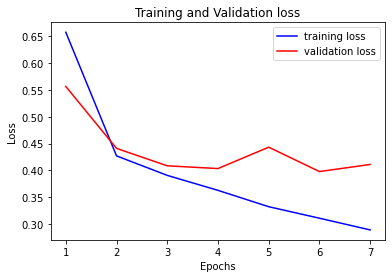

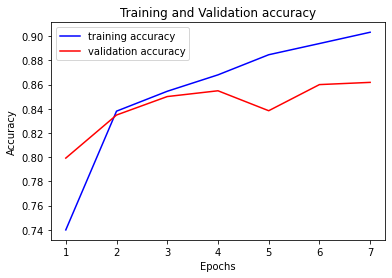

In [9]:

# model.fit() returns a History object that contains a dictionary with everything that happened during training
# we can use it to plot training/validation loss and training/validation accuracy
history_dict = history.history
print (history_dict.keys())

# plot total loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy for clshead
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2022-04-28 18:18:53.241801: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


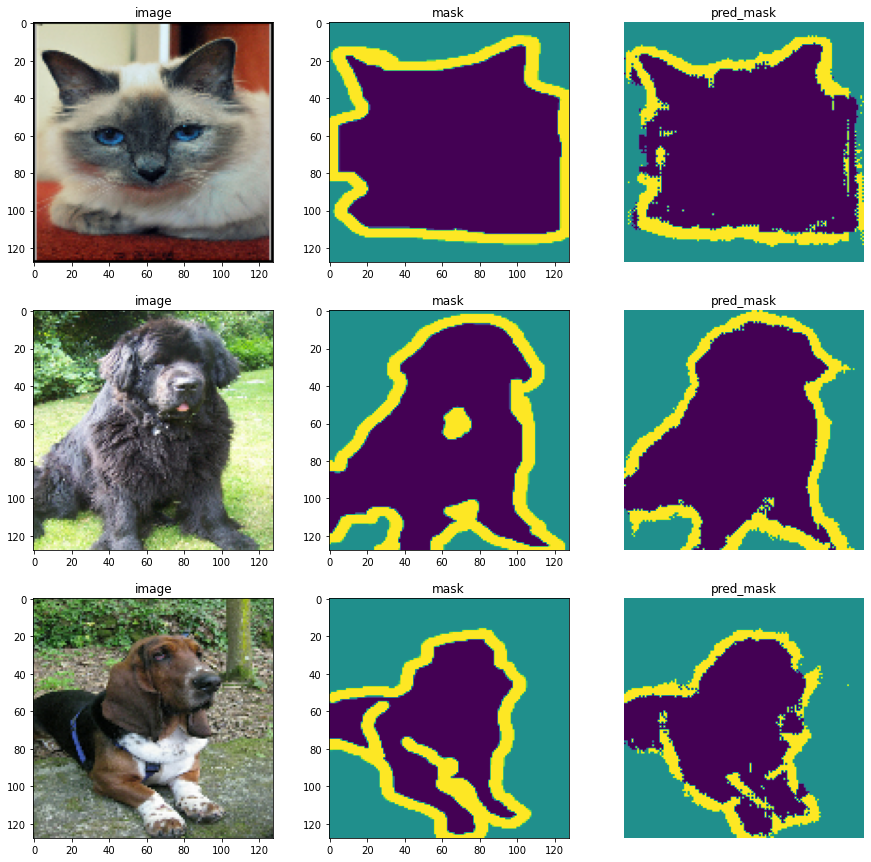

In [10]:

# make predictions
# code adapted from https://www.tensorflow.org/tutorials/images/segmentation

plt.figure(figsize=(15, 15))
i = 0
for image, mask in test_ds.take(3):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.title('image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    
    ax = plt.subplot(3, 3, i + 2)
    plt.title('mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    
    ax = plt.subplot(3, 3, i + 3)
    plt.title('pred_mask')
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))
    
    plt.axis("off")
    i = i + 3